In [121]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
numpyro.enable_x64()    

import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import jax.random as random
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
from datetime import datetime
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.lines import Line2D

import seaborn as sns
import warnings
warnings.simplefilter('ignore')


class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# --------------------------------------------------------
# helper: draw one decomposition in an existing Axes
# --------------------------------------------------------
def plot_decomposition_ax(ax, date, original, trend, cycle, title, loc="upper left"):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # level & trend  ------------------------
    ax.plot(date, original, label="Original", color=colors[0])
    ax.plot(date, trend,    label="Trend",    color=colors[1])
    ax.set_xlabel("Year")
    ax.set_ylabel("level / trend")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)

    # cycle (twin axis) ---------------------
    ax2 = ax.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2])
    ax2.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax2.set_ylabel("Cycle")
    ax2.tick_params(axis="y", colors=colors[2])

    # legend (combine both axes) ------------
    lines  = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=loc, frameon=False)


## Estimation

NKPC under HSA

$$
\hat{\pi}_{t}=\beta\left(1-\delta\right)\mathbb{E}_{t}\hat{\pi}_{t+1}+\overset{\text{steady-state effect}}{\overbrace{\frac{\zeta\left(z\right)-1}{\chi}}}\left(\hat{W}_{t}-\hat{Z}_{P,t}-\hat{p}_{t}\right)-\overset{\text{dynamic effect}}{\overbrace{\frac{1}{\chi}\frac{1-\rho\left(z\right)}{\rho\left(z\right)}\hat{N}_{t}}}
$$

Note that $s\left(z_{t}\right)=\frac{1}{N_{t}}$ and $Y_{t}=\frac{1}{\mu_{t}}=\left(\hat{W}_{t}-\hat{Z}_{P,t}-\hat{p}_{t}\right)$

Estimation strategy

$N_{t}$ denotes the measure of the number of firms (varieties), or the inverse of concentration, and $x_{t}$ denotes the measure of the output gap or the inverse of the markup.

---
---
# Estimation strategies (3 patterns)
### NKPC under CES (Benchmark)
$s(z_t) = \gamma_{CES}(z_t)^{1−\theta}$

$\theta$ denotes the constant price elasticity, and $\zeta(z) = \theta$ and $\rho(z) = 1$:
$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t-1}+\underset{\kappa}{\underbrace{\frac{\theta-1}{\chi}}}x_{t}+v_{t}
$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

Estimated parameters are $\alpha$, $\theta$, $\chi$ and $\sigma_{v}$.

$\chi$: scales the size of the cost

$\theta$: the constant price elasticity,


### NKPC under HSA

$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\underset{\kappa}{\underbrace{\frac{\zeta(z)-1}{\chi}}}x_{t}-\underset{\theta}{\underbrace{\frac{1-\rho(z)}{\rho(z)\chi}}}\hat{N}_{t}+v_{t},
$$
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
where
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\epsilon_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\eta_{t},
$$

$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad \eta_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

Estimated parameters are $\alpha$, $\kappa$, $\theta$, $\rho_1$, $\rho_2$, $n$, $\psi$,  $\sigma_{v}$, $\sigma_{\epsilon}$, and $\sigma_{\eta}$.

$\zeta(z) = 1-\frac{s′(z)z}{s(z)}$ : the price elasticity function $\zeta(z) > 1$

$\rho(z)=[1-\frac{dln(\frac{\zeta(z)}{\zeta(z)-1})}{dln(z)}]^{-1}$   : the pass-through rate function, $1 >\rho(z) > 0$



## Restrictions on the estimation strategies
$0<\alpha<1$,

$0<\kappa$,  

$0<\theta$

$0<\psi$ 

$\rho_1$ and $\rho_2$ must satisfy 

$\rho_2 - \rho_1 < 1$

$\rho_2 + \rho_1 < 1$

$|\rho_2| < 1$

To satisfy $\rho$ restrictions, 
we set prior for $\rho_1$ as a uniform distribution over $(0,2)$ and prior for $\rho_2$ as a uniform distribution over $(-1,0)$.

In addition, we don't adopt pairs of $\rho_1$ and $\rho_2$ which is not satisfying $\rho$ restrictions.



Another way:
we first sample the damping factor ($-1<r<1$) and frequency of the cycle($0<p<1$) and then calculate $\rho_1 = 2rcos(\pi p)$ and $\rho_2 = -r^2$.

$z^2 - \rho_1 z - \rho_2=0$

$z_{1,2} = r e^{\pm i \pi p}$ 

Therefore, 

$\rho_1 = z_1 + z_2 = r e^{i \pi p} + r e^{-i \pi p}= 2 r \cos(\pi p)$

$\rho_2 = -z_1 z_2 = - r^2$

In [122]:
# cpi data
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])

# Markup data
data_markup = pd.read_excel("data/nekarda_ramey_markups.xlsx")
data_markup['DATE'] = pd.to_datetime(data_markup['qdate'], format='%Y-%m-%d')
data_markup['markup'] = data_markup['mu_bus']
data_markup = data_markup[['DATE', 'markup']].dropna()

# output gap data
data_output = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_output['output_BN'] = data_output['GDPC1_transformed_series']
data_output['output_gap_BN'] = data_output["cycle"]
data_output['output'] = np.log(data_output["GDPC1_original_series"] * 0.01)
data_output['DATE'] = data_output["date"]
data_output["output_trend_BN"] = data_output["output_BN"] - data_output["output_gap_BN"]
data_output = data_output[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]].dropna()
data_output['DATE'] = pd.to_datetime(data_output['DATE'])


# inflation expectation data
data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

# HHI
data_N_annual = pd.read_excel("data/WITS-Country-Timeseries.xlsx")
data_N_annual["HHI"] = data_N_annual["Unnamed: 1"]
data_N_annual['year'] = pd.to_datetime(data_N_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_annual = data_N_annual.set_index('year')
data_N = data_N_annual.resample('QS').asfreq()
data_N['HHI'] = data_N['HHI'].interpolate(method='linear')
data_N = data_N.reset_index()
data_N['DATE'] = pd.to_datetime(data_N['year'])
data_N = data_N[["DATE", "HHI"]]
data_N["N"] = np.log(1/data_N["HHI"]) 
data_N.to_csv("data/N_HHI.csv", index=False)

# Merge all dataframes
data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_output, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")
data = pd.merge(data, data_markup, on="DATE", how="outer")
data["output_gap_BN"] = data["output_gap_BN"]
data["markup"] = data["markup"]
data["N"] = data["N"]

data["pi_prev"] = data["pi"].shift(1)
data["output_gap_prev"] = data["output_gap_BN"].shift(1)
data["markup_prev"] = data["markup"].shift(1)
data['N_prev'] = data['N'].shift(1)
data = data.dropna()
data_1 = data[data['DATE'] >= '2008-04-01']
data_2 = data[data['DATE'] < '2009-01-01']
# for MCMC
pi_1 = jnp.array(data_1['pi'],dtype=jnp.float64)
pi_prev_1 = jnp.array(data_1['pi_prev'],dtype=jnp.float64)
pi_expect_1 = jnp.array(data_1['Epi'],dtype=jnp.float64)
N_1 = jnp.array(data_1['N'],dtype=jnp.float64)
Y_1 = jnp.array(data_1['output'],dtype=jnp.float64)
x_markup_1 = jnp.array(1/data_1['markup'],dtype=jnp.float64)
x_output_gap_1 = jnp.array(data_1['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev_1 = jnp.array(data_1['output_gap_prev'],dtype=jnp.float64)
x_markup_prev_1 = jnp.array(1/data_1['markup_prev'],dtype=jnp.float64)

pi_2 = jnp.array(data_2['pi'],dtype=jnp.float64)
pi_prev_2 = jnp.array(data_2['pi_prev'],dtype=jnp.float64)
pi_expect_2 = jnp.array(data_2['Epi'],dtype=jnp.float64)
N_2 = jnp.array(data_2['N'],dtype=jnp.float64)
Y_2 = jnp.array(data_2['output'],dtype=jnp.float64)
x_markup_2 = jnp.array(1/data_2['markup'],dtype=jnp.float64)
x_output_gap_2 = jnp.array(data_2['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev_2 = jnp.array(data_2['output_gap_prev'],dtype=jnp.float64)
x_markup_prev_2 = jnp.array(1/data_2['markup_prev'],dtype=jnp.float64)

In [131]:
warmup= 1000
samples=4000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

def set_prior_distributions():
    priors = {
        # NKPC params
        "alpha"      : dist.Beta(2, 5),
        "kappa"      : dist.Beta(2, 5),
        "kappa_init" : dist.Beta(2, 5),
        "theta"      : dist.Normal(0, 1), 
        "delta"      : dist.Normal(0, 1), 
        "n"          : dist.Normal(0, 1), 
        # Sigma
        "sigma_u"    : dist.LogNormal(0, 1),  
        "sigma_eps"  : dist.LogNormal(0, 1),  
        "sigma_v"    : dist.LogNormal(0, 1),  
        "sigma_mu"   : dist.LogNormal(0, 1),  
        "sigma_e"    : dist.LogNormal(0, 1),  
        "sigma_eta"  : dist.LogNormal(0, 1),  
    }
    return priors

In [132]:
def model_0(pi, pi_prev, pi_expect, x):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha", priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_v = numpyro.sample("sigma_v", priors["sigma_v"])
    # model
    pi_pred = alpha * pi_prev + (1-alpha) * pi_expect + kappa * x
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi)


# NKPC under CES before financial crisis =================================================
print("NKPC under CES")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc_1_1 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_1_1.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1)
idata_0_1 = az.from_numpyro(mcmc_1_1)
posterior_samples = mcmc_1_1.get_samples()
diverging  = idata_0_1.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param
# NKPC under CES after financial crisis =================================================
kernel = NUTS(model_0, target_accept_prob=0.995)    
mcmc_1_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_1_2.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_markup_2)
idata_0_2 = az.from_numpyro(mcmc_1_2)
posterior_samples_2 = mcmc_1_2.get_samples()
diverging  = idata_0_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param


NKPC under CES


sample: 100%|██████████| 5000/5000 [00:01<00:00, 3285.16it/s, 15 steps of size 1.97e-01. acc. prob=0.99]


model 0: divergence ratio = 0.0000%


sample: 100%|██████████| 5000/5000 [00:02<00:00, 2405.73it/s, 15 steps of size 2.00e-01. acc. prob=0.99]


model 0: divergence ratio = 0.0000%


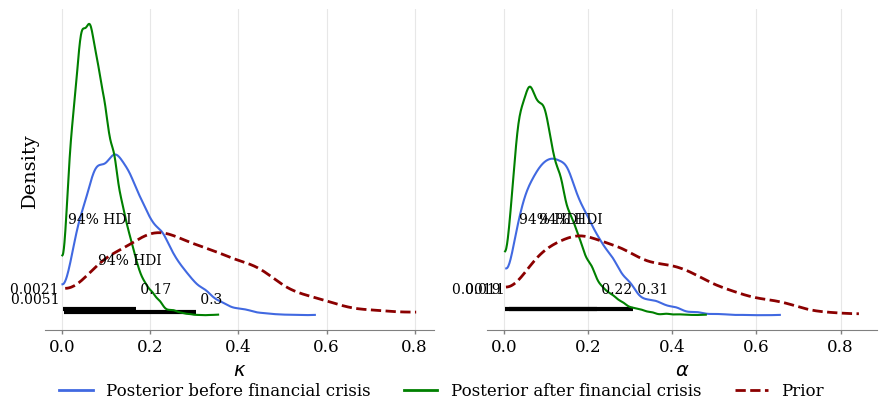

In [133]:
rng = random.PRNGKey(123)
prior_pred = Predictive(model_0, num_samples=1000)
prior_draws = prior_pred(rng, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1)
param_names = [ "alpha", "kappa"]
prior_dict = {k: v for k, v in prior_draws.items() if k in param_names}
idata_prior = az.from_dict(prior=prior_dict)

fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
params = ["kappa", "alpha"]
labels = [r"$\kappa$", r"$\alpha$"]
for ax, param, label in zip(axes, params, labels):
    # Posterior
    az.plot_posterior(
        idata_0_1,
        var_names=[param],
        point_estimate=None,
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_0_2,
        var_names=[param],
        point_estimate=None,
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    # Prior
    az.plot_dist(
        idata_prior.prior[param],
        ax=ax,
        color="darkred",
        fill_kwargs=None,
        plot_kwargs={"ls": "--", "lw": 2},
    )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)
    
axes[0].set_ylabel("Density", fontsize=14)
axes[1].set_ylabel("")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred", lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

In [134]:
def model_1(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))   # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, .05))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        t = carry[3]
        # state equation
        # trend 
        Nbar_t = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1 , t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, t], timesteps)

In [135]:
# NKPC under HSA : no shift in slope / before financial crisis ==============================
print("NKPC under HSA : no shift in slope, before financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.99)
mcmc_1_1 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_1.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1, N = N_1, l=len(pi_1))
idata_1_1 = az.from_numpyro(mcmc_1_1)
posterior_samples_1_1 = mcmc_1_1.get_samples()
N_bar_samples_1_1 = posterior_samples_1_1["Nbar"]
N_bar_mean_1_1 = np.mean(N_bar_samples_1_1, axis=0) 
N_bar_std_1_1 = np.std(N_bar_samples_1_1, axis=0)  
N_bar_lower_1_1 = N_bar_mean_1_1 - 1.97 * N_bar_std_1_1
N_bar_upper_1_1 = N_bar_mean_1_1 + 1.97 * N_bar_std_1_1
N_hat_samples_1_1 = posterior_samples_1_1["Nhat"]
N_hat_mean_1_1 = np.mean(N_hat_samples_1_1, axis=0) 
N_hat_std_1_1 = np.std(N_hat_samples_1_1, axis=0)  
N_hat_lower_1_1 = N_hat_mean_1_1 - 1.97 * N_hat_std_1_1
N_hat_upper_1_1 = N_hat_mean_1_1 + 1.97 * N_hat_std_1_1
diverging  = idata_1_1.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# NKPC under HSA : no shift in slope / after financial crisis ==============================
print("NKPC under HSA : no shift in slope, after financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.99)
mcmc_1_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_2.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_markup_2, N = N_2, l=len(pi_2))
idata_1_2 = az.from_numpyro(mcmc_1_2)
posterior_samples_1_2 = mcmc_1_2.get_samples()
N_bar_samples_1_2 = posterior_samples_1_2["Nbar"]
N_bar_mean_1_2 = np.mean(N_bar_samples_1_2, axis=0) 
N_bar_std_1_2 = np.std(N_bar_samples_1_2, axis=0)  
N_bar_lower_1_2 = N_bar_mean_1_2 - 1.97 * N_bar_std_1_2
N_bar_upper_1_2 = N_bar_mean_1_2 + 1.97 * N_bar_std_1_2
N_hat_samples_1_2 = posterior_samples_1_2["Nhat"]
N_hat_mean_1_2 = np.mean(N_hat_samples_1_2, axis=0) 
N_hat_std_1_2 = np.std(N_hat_samples_1_2, axis=0)  
N_hat_lower_1_2 = N_hat_mean_1_2 - 1.97 * N_hat_std_1_2
N_hat_upper_1_2 = N_hat_mean_1_2 + 1.97 * N_hat_std_1_2
diverging  = idata_1_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

NKPC under HSA : no shift in slope, before financial crisis


sample: 100%|██████████| 5000/5000 [01:03<00:00, 79.27it/s, 255 steps of size 1.43e-02. acc. prob=0.99] 


Model 1 : divergence ratio = 0.0000%
NKPC under HSA : no shift in slope, after financial crisis


sample: 100%|██████████| 5000/5000 [05:22<00:00, 15.52it/s, 511 steps of size 8.02e-03. acc. prob=0.99] 


Model 1 : divergence ratio = 0.0000%


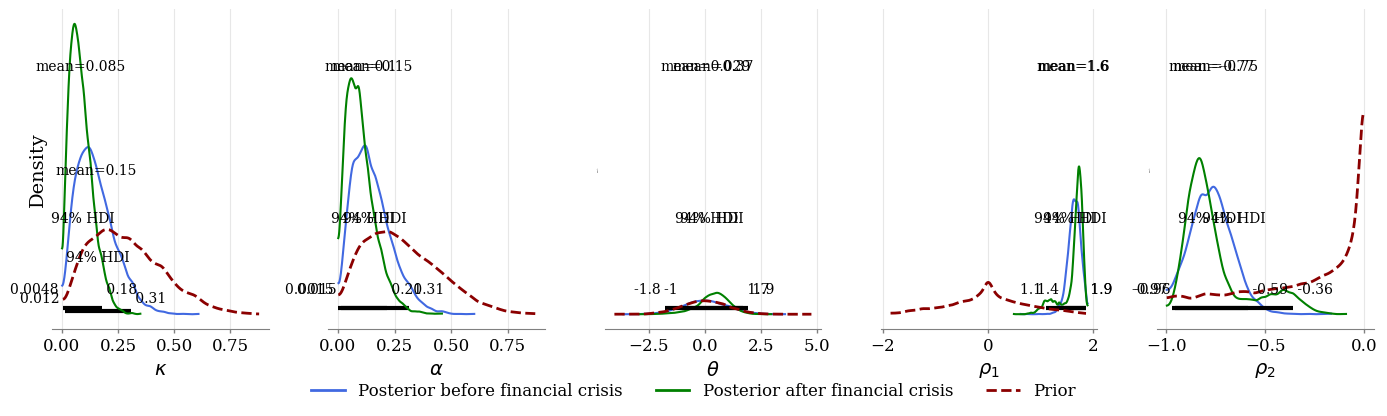

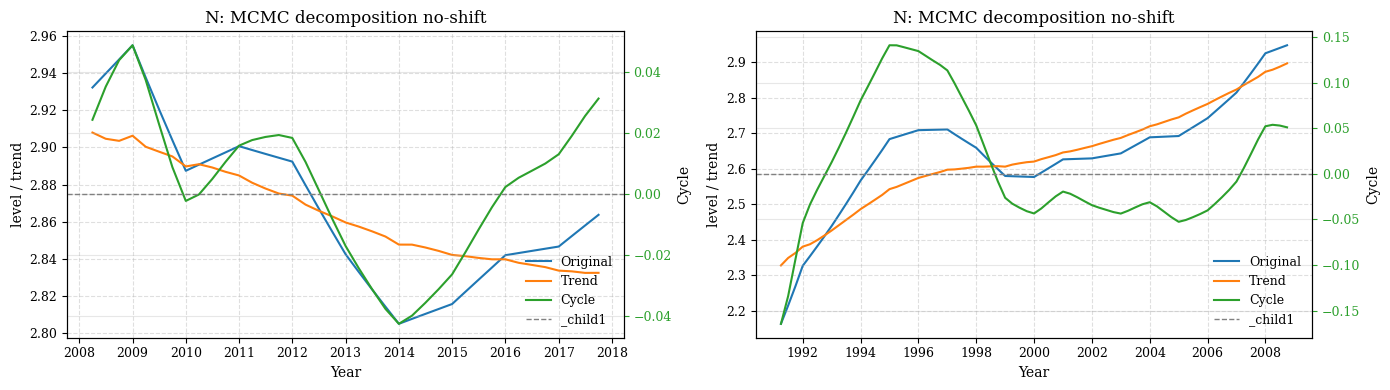

In [136]:
prior_pred_1 = Predictive(model_1, num_samples=10000)
prior_draws_1 = prior_pred_1(rng, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1, N=N_1, l=len(pi_1))
params = ["kappa", "alpha", "theta", "rho_1", "rho_2"]
labels = [r"$\kappa$", r"$\alpha$", r"$\theta$", r"$\rho_{1}$", r"$\rho_{2}$"]

prior_dict_1 = {k: prior_draws_1[k] for k in params if k in prior_draws_1}
idata_prior_1 = az.from_dict(prior=prior_dict_1)

fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)
axes_flat = axes.ravel()

for ax, param, label in zip(axes_flat, params, labels):
    az.plot_posterior(
        idata_1_1,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_1_2,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    if hasattr(idata_prior_1, "prior") and (param in idata_prior_1.prior.data_vars):
        az.plot_dist(
            idata_prior_1.prior[param],
            ax=ax,
            color="darkred",
            fill_kwargs=None,
            plot_kwargs={"ls": "--", "lw": 2},
        )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

for i, ax in enumerate(axes_flat):
    ax.set_ylabel("Density", fontsize=14 if i % 5 == 0 else 0)
    if i % 2 == 1:
        ax.set_ylabel("")

for j in range(len(params), len(axes_flat)):
    axes_flat[j].axis("off")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred",  lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

scale = 2
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=False)
# First decomposition: no shift
plot_decomposition_ax(
    axes[0],
    data_1["DATE"], data_1["N"], N_bar_mean_1_1, N_hat_mean_1_1,
    "N: MCMC decomposition no-shift", loc="lower right"
)
plot_decomposition_ax(
    axes[1],
    data_2["DATE"], data_2["N"], N_bar_mean_1_2, N_hat_mean_1_2,
    "N: MCMC decomposition no-shift", loc="lower right"
)
plt.tight_layout()
plt.show()

In [ ]:
dict_idata = {
    'NKPC: CES before financial crisis':idata_0_1, 'CES after financial crisis':idata_0_2,
    'NKPC: HSA no-shift after financial crisis':idata_1_1, 'NKPC: HSA no-shift before financial crisis':idata_1_2,
    }

params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2",  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

,model,alpha,kappa,theta,rho_1,rho_2,n
0,NKPC: CES before financial crisis,0.185,0.189,-,-,-,-
1,CES after financial crisis,0.121,0.091,-,-,-,-
2,NKPC: HSA no-shift after financial crisis,0.185,0.188,0.499,1.641,-0.770,-0.002
3,NKPC: HSA no-shift before financial crisis,0.117,0.092,0.525,1.633,-0.758,0.008


## Model Comparison

## WAIC
（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
- log pointwise predictive density
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
This term measures the average fit of the model across all posterior draws. It’s like the average log-likelihood, but averaged over the posterior.
- effective number of parameters
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$
This captures how much the log-likelihood varies across posterior samples for each data point. High variance means the model is more complex (more sensitive to the choice of parameters), so it penalizes complexity.

## Leave-One-Out (LOO) cross-validation
The LOO expected log predictive density is defined as
$$
\operatorname{elpd}_{\text{loo}}
\;=\;
\sum_{i=1}^{n}
  \log p\!\bigl(y_i \,\mid\, y_{-i}\bigr).
$$

where
$$
p\!\bigl(y_i \mid y_{-i}\bigr)
\;=\;
\int
  p\!\bigl(y_i \mid \boldsymbol{\theta}\bigr)\,
  p\!\bigl(\boldsymbol{\theta} \mid y_{-i}\bigr)\,
d\boldsymbol{\theta}
$$

**Interpretation** : 

$\operatorname{elpd}_{\text{loo}}$ sums the log predictive density for each observation when that observation is left out of the estimation.  Higher values indicate better out-of-sample predictive accuracy.

**Efficient computation**:

In practice we approximate (4)–(5) using \emph{PSIS-LOO} (Pareto-smoothed importance sampling), which avoids refitting the model $n$ times.

**Complexity penalty**: 
An effective number of parameters can be defined analogously to WAIC as
  $$
    p_{\text{LOO}} \;=\; \sum_{i=1}^{n} \operatorname{Var}_{\theta}
      \!\bigl(\log p(y_i \mid \boldsymbol{\theta})\bigr),
  $$
  so that $\text{LOOIC} = -2\,(\operatorname{elpd}_{\text{loo}} - p_{\text{LOO}})$.

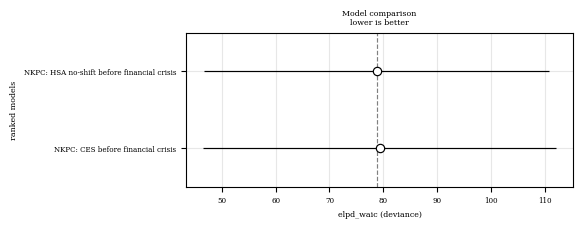

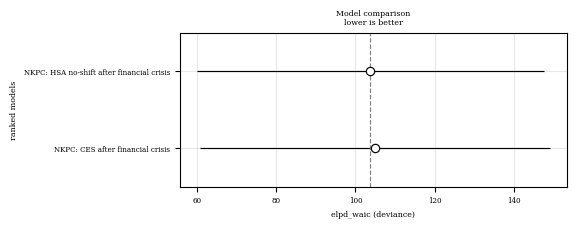

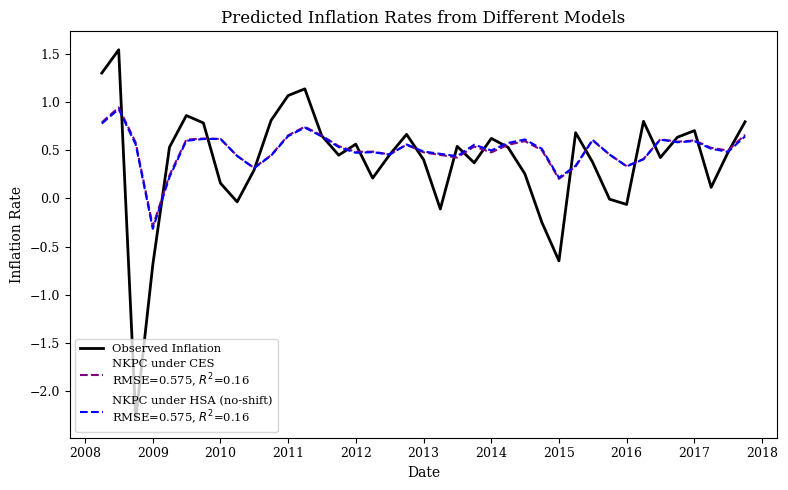

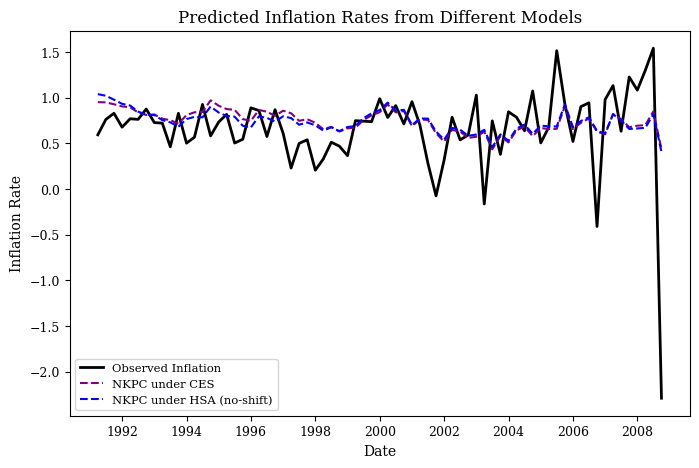

In [ ]:
# WAIC
dict_idata = {
    'NKPC: CES before financial crisis':idata_0_1, 'NKPC: HSA no-shift before financial crisis':idata_1_1,
    }
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))
# df_loo = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')

dict_idata = {
    'NKPC: CES after financial crisis':idata_0_2, 'NKPC: HSA no-shift after financial crisis':idata_1_2,
    }
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))
# df_loo = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')

# az.plot_compare(df_loo, figsize=(2.5*scale, 1*scale))
pi_prd_0_1  = idata_0_1.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_0_1.posterior["alpha"].mean().item()) * pi_expect_1 + idata_0_1.posterior["kappa"].mean().item() * x_markup_1
pi_prd_0_2  = idata_0_2.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_0_2.posterior["alpha"].mean().item()) * pi_expect_2 + idata_0_2.posterior["kappa"].mean().item() * x_markup_2
pi_pred_1_1 = idata_1_1.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_1_1.posterior["alpha"].mean().item()) * pi_expect_1 + idata_1_1.posterior["kappa"].mean().item() * x_markup_1 - idata_1_1.posterior["theta"].mean().item() * N_hat_mean_1_1
pi_pred_1_2 = idata_1_2.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_1_2.posterior["alpha"].mean().item()) * pi_expect_2 + idata_1_2.posterior["kappa"].mean().item() * x_markup_2 - idata_1_2.posterior["theta"].mean().item() * N_hat_mean_1_2

# --- after you compute pi_pred_1…pi_pred_4 ---
def rmse(pred, obs):
    return np.sqrt(np.mean((pred - obs)**2))

def r2(pred, obs):
    ss_res = np.sum((obs - pred)**2)
    ss_tot = np.sum((obs - np.mean(obs))**2)
    return 1 - ss_res/ss_tot

# compute metrics
rmse0_1, r20_1 = rmse(pi_prd_0_1, pi_1), r2(pi_prd_0_1, pi_1)
rmse0_2, r20_2 = rmse(pi_prd_0_2, pi_2), r2(pi_prd_0_2, pi_2)
rmse1_1, r21_1 = rmse(pi_pred_1_1, pi_1), r2(pi_pred_1_1, pi_1)
rmse1_2, r21_2 = rmse(pi_pred_1_2, pi_2), r2(pi_pred_1_2, pi_2)

# Plotting the predicted inflation rates
plt.figure(figsize=(8, 5))
plt.plot(data_1["DATE"], pi_1, label="Observed Inflation", color='black', linewidth=2)
plt.plot(
    data_1["DATE"], pi_prd_0_1,
    label=f"NKPC under CES \nRMSE={rmse0_1:.3f}, $R^2$={r20_1:.2f}",
    color='purple', linestyle='--'
)
plt.plot(
    data_1["DATE"], pi_pred_1_1,
    label=f"NKPC under HSA (no-shift)\nRMSE={rmse1_1:.3f}, $R^2$={r21_1:.2f}",
    color='blue', linestyle='--'
)
plt.title("Predicted Inflation Rates from Different Models")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.legend(loc="lower left", fontsize='small', framealpha=0.8)
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(data_2["DATE"], pi_2, label="Observed Inflation", color='black', linewidth=2)
plt.plot(data_2["DATE"], pi_prd_0_2, label="NKPC under CES", color='purple', linestyle='--')
plt.plot(data_2["DATE"], pi_pred_1_2, label="NKPC under HSA (no-shift)", color='blue', linestyle='--')
plt.title("Predicted Inflation Rates from Different Models")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.legend(loc="lower left", fontsize='small', framealpha=0.8)
plt.grid()

### Additional: Shift in the slope
$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\underset{\kappa}{\underbrace{\frac{\zeta(z)-1}{\chi}}}x_{t}-\underset{\theta}{\underbrace{\frac{1-\rho(z)}{\rho(z)\chi}}}\hat{N}_{t}+v_{t},
$$
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
where
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\epsilon_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\eta_{t},
$$

$$\begin{cases}
case 1 & \Delta\kappa_{t}=\delta\Delta\bar{N}_{t}\\
case 2 & \Delta\kappa_{t}=\delta\Delta\bar{N}_{t}+e_{t}\\
\end{cases}$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2), \quad e_t \sim \mathcal{N}(0, \sigma_{e}^2)
$$

Estimated parameters are $\alpha$, $\kappa$, $\theta$, $\rho_1$, $\rho_2$, $n$, $\delta$, $\sigma_{\epsilon}$, $\sigma_{\eta}$, $\sigma_{e}$.



In [ ]:
def model_case1(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    delta = numpyro.sample("delta", priors["delta"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_eta  = numpyro.sample("sigma_u", priors["sigma_eta"])    
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))  # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, 0.1))  # Nhat init
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # N 
        Nbar_t = numpyro.sample("Nbar", dist.Normal( n + Nbar_prev, sigma_eta))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_eps), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # kappa
        kappa_t = numpyro.deterministic("kappa", kappa_prev + delta * (Nbar_t - Nbar_prev))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_prev, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa_0 , t], timesteps)
def model_case2(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    delta = numpyro.sample("delta", priors["delta"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_eta  = numpyro.sample("sigma_u", priors["sigma_eta"])    
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))  # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, 0.1))  # Nhat init
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # N 
        Nbar_t = numpyro.sample("Nbar", dist.Normal( n + Nbar_prev, sigma_eta))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_eps), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # kappa
        kappa_t = numpyro.sample("kappa", dist.Normal(kappa_prev + delta * (Nbar_t - Nbar_prev), sigma_e))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_prev, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa_0 , t], timesteps)

In [ ]:
print("case 1")
kernel = NUTS(model_case1, target_accept_prob=0.99)
mcmc_case1_1 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_case1_1.run(rng_keys, pi=pi_1,pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1, N=N_1, l=len(pi_1))
idata_case1_1 = az.from_numpyro(mcmc_case1_1)
diverging  = idata_case1_1.sample_stats["diverging"].values
ratio_div  = diverging.mean()        
print(f"case 1 : divergence ratio = {ratio_div:.4%}")
kernel = NUTS(model_case1, target_accept_prob=0.99)
mcmc_case1_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_case1_2.run(rng_keys, pi=pi_2,pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_markup_2, N=N_2, l=len(pi_2))
idata_case1_2 = az.from_numpyro(mcmc_case1_1)
diverging  = idata_case1_2.sample_stats["diverging"].values
ratio_div  = diverging.mean()        
print(f"case 1 : divergence ratio = {ratio_div:.4%}")

print("case 2")
kernel = NUTS(model_case2, target_accept_prob=0.99)
mcmc_case2_1 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel", progress_bar=True)
mcmc_case2_1.run(rng_keys, pi=pi_1,pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1, N=N_1, l=len(pi_1))
idata_case2_1 = az.from_numpyro(mcmc_case2_1)
diverging  = idata_case2_1.sample_stats["diverging"].values
ratio_div  = diverging.mean()
print(f"case 2 : divergence ratio = {ratio_div:.4%}")
kernel = NUTS(model_case2, target_accept_prob=0.99)
mcmc_case2_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel", progress_bar=True)
mcmc_case2_2.run(rng_keys, pi=pi_2,pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_markup_2, N=N_2, l=len(pi_2))
idata_case2_2 = az.from_numpyro(mcmc_case2_2)
diverging  = idata_case2_2.sample_stats["diverging"].values
ratio_div  = diverging.mean()
print(f"case 2 : divergence ratio = {ratio_div:.4%}")

case 1


sample: 100%|██████████| 5000/5000 [00:35<00:00, 140.06it/s, 255 steps of size 4.70e-02. acc. prob=0.90]


case 1 : divergence ratio = 0.0500%


sample: 100%|██████████| 5000/5000 [02:52<00:00, 29.04it/s, 63 steps of size 3.78e-02. acc. prob=0.85] 


case 1 : divergence ratio = 0.0500%
case 2


sample: 100%|██████████| 5000/5000 [00:37<00:00, 134.67it/s, 127 steps of size 3.85e-02. acc. prob=0.91]


case 2 : divergence ratio = 0.0250%


sample: 100%|██████████| 5000/5000 [02:05<00:00, 39.79it/s, 63 steps of size 3.71e-02. acc. prob=0.87] 


case 2 : divergence ratio = 0.0000%


In [ ]:
# Results
posterior_samples_case1_1 = mcmc_case1_1.get_samples()
N_bar_samples_case1_1 = posterior_samples_case1_1["Nbar"]   
N_bar_mean_case1_1 = np.mean(N_bar_samples_case1_1, axis=0)
N_bar_std_case1_1 = np.std(N_bar_samples_case1_1, axis=0)
N_bar_lower_case1_1 = N_bar_mean_case1_1 - 1.97 * N_bar_std_case1_1
N_bar_upper_case1_1 = N_bar_mean_case1_1 + 1.97 * N_bar_std_case1_1

N_hat_samples_case1_1 = posterior_samples_case1_1["Nhat"]
N_hat_mean_case1_1 = np.mean(N_hat_samples_case1_1, axis=0) 
N_hat_std_case1_1 = np.std(N_hat_samples_case1_1, axis=0)
N_hat_lower_case1_1 = N_hat_mean_case1_1 - 1.97 * N_hat_std_case1_1
N_hat_upper_case1_1 = N_hat_mean_case1_1 + 1.97 * N_hat_std_case1_1

kappa_samples_case1_1 = posterior_samples_case1_1["kappa"]
kappa_mean_case1_1 = np.mean(kappa_samples_case1_1, axis=0)
kappa_std_case1_1 = np.std(kappa_samples_case1_1, axis=0)
kappa_lower_case1_1 = kappa_mean_case1_1 - 1.97 * kappa_std_case1_1
kappa_upper_case1_1 = kappa_mean_case1_1 + 1.97 * kappa_std_case1_1
# --------------------------------------------------------
posterior_samples_case1_2 = mcmc_case1_2.get_samples()
N_bar_samples_case1_2 = posterior_samples_case1_2["Nbar"]
N_bar_mean_case1_2 = np.mean(N_bar_samples_case1_2, axis=0)
N_bar_std_case1_2 = np.std(N_bar_samples_case1_2, axis=0)
N_bar_lower_case1_2 = N_bar_mean_case1_2 - 1.97 * N_bar_std_case1_2
N_bar_upper_case1_2 = N_bar_mean_case1_2 + 1.97 * N_bar_std_case1_2

N_hat_samples_case1_2 = posterior_samples_case1_2["Nhat"]
N_hat_mean_case1_2 = np.mean(N_hat_samples_case1_2, axis=0)
N_hat_std_case1_2 = np.std(N_hat_samples_case1_2, axis=0)
N_hat_lower_case1_2 = N_hat_mean_case1_2 - 1.97 * N_hat_std_case1_2
N_hat_upper_case1_2 = N_hat_mean_case1_2 + 1.97 * N_hat_std_case1_2

kappa_samples_case1_2 = posterior_samples_case1_2["kappa"]
kappa_mean_case1_2 = np.mean(kappa_samples_case1_2, axis=0)
kappa_std_case1_2 = np.std(kappa_samples_case1_2, axis=0)
kappa_lower_case1_2 = kappa_mean_case1_2 - 1.97 * kappa_std_case1_2
kappa_upper_case1_2 = kappa_mean_case1_2 + 1.97 * kappa_std_case1_2
# --------------------------------------------------------
posterior_samples_case2_1 = mcmc_case2_1.get_samples()
N_bar_samples_case2_1 = posterior_samples_case2_1["Nbar"]
N_bar_mean_case2_1 = np.mean(N_bar_samples_case2_1, axis=0)
N_bar_std_case2_1 = np.std(N_bar_samples_case2_1, axis=0)
N_bar_lower_case2_1 = N_bar_mean_case2_1 - 1.97 * N_bar_std_case2_1
N_bar_upper_case2_1 = N_bar_mean_case2_1 + 1.97 * N_bar_std_case2_1

N_hat_samples_case2_1 = posterior_samples_case2_1["Nhat"]
N_hat_mean_case2_1 = np.mean(N_hat_samples_case2_1, axis=0)
N_hat_std_case2_1 = np.std(N_hat_samples_case2_1, axis=0)
N_hat_lower_case2_1 = N_hat_mean_case2_1 - 1.97 * N_hat_std_case2_1
N_hat_upper_case2_1 = N_hat_mean_case2_1 + 1.97 * N_hat_std_case2_1

kappa_samples_case2_1 = posterior_samples_case2_1["kappa"]
kappa_mean_case2_1 = np.mean(kappa_samples_case2_1, axis=0)
kappa_std_case2_1 = np.std(kappa_samples_case2_1, axis=0)
kappa_lower_case2_1 = kappa_mean_case2_1 - 1.97 * kappa_std_case2_1
kappa_upper_case2_1 = kappa_mean_case2_1 + 1.97 * kappa_std_case2_1
# --------------------------------------------------------
posterior_samples_case2_2 = mcmc_case2_2.get_samples()
N_bar_samples_case2_2 = posterior_samples_case2_2["Nbar"]
N_bar_mean_case2_2 = np.mean(N_bar_samples_case2_2, axis=0)
N_bar_std_case2_2 = np.std(N_bar_samples_case2_2, axis=0)
N_bar_lower_case2_2 = N_bar_mean_case2_2 - 1.97 * N_bar_std_case2_2
N_bar_upper_case2_2 = N_bar_mean_case2_2 + 1.97 * N_bar_std_case2_2

N_hat_samples_case2_2 = posterior_samples_case2_2["Nhat"]
N_hat_mean_case2_2 = np.mean(N_hat_samples_case2_2, axis=0)
N_hat_std_case2_2 = np.std(N_hat_samples_case2_2, axis=0)
N_hat_lower_case2_2 = N_hat_mean_case2_2 - 1.97 * N_hat_std_case2_2
N_hat_upper_case2_2 = N_hat_mean_case2_2 + 1.97 * N_hat_std_case2_2

kappa_samples_case2_2 = posterior_samples_case2_2["kappa"]
kappa_mean_case2_2 = np.mean(kappa_samples_case2_2, axis=0)
kappa_std_case2_2 = np.std(kappa_samples_case2_2, axis=0)
kappa_lower_case2_2 = kappa_mean_case2_2 - 1.97 * kappa_std_case2_2
kappa_upper_case2_2 = kappa_mean_case2_2 + 1.97 * kappa_std_case2_2


In [ ]:
dict_idata = {
    'CES before financial crisis':idata_0_1, 'CES after financial crisis':idata_0_2,
    'HSA before financial crisis':idata_1_2, 'HSA after financial crisis':idata_1_2,
    'HSA before financial crisis, case 1': idata_case1_1, 'HSA after financial crisis, case 1': idata_case1_2,
    'HSA before financial crisis, case 2': idata_case2_1, 'HSA after financial crisis, case 2': idata_case2_2,
    }
params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2",  "n", "delta",
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

,model,alpha,kappa,theta,rho_1,rho_2,n,delta
0,CES before financial crisis,0.185,0.189,-,-,-,-,-
1,CES after financial crisis,0.121,0.091,-,-,-,-,-
2,HSA before financial crisis,0.117,0.092,0.525,1.633,-0.758,0.008,-
3,HSA after financial crisis,0.117,0.092,0.525,1.633,-0.758,0.008,-
4,"HSA before financial crisis, case 1",0.186,-,0.502,1.621,-0.754,-0.002,0.500
5,"HSA after financial crisis, case 1",0.186,-,0.502,1.621,-0.754,-0.002,0.500
6,"HSA before financial crisis, case 2",0.188,-,0.498,1.635,-0.765,-0.002,0.502
7,"HSA after financial crisis, case 2",0.123,-,0.506,1.731,-0.832,0.006,0.495


# case 1

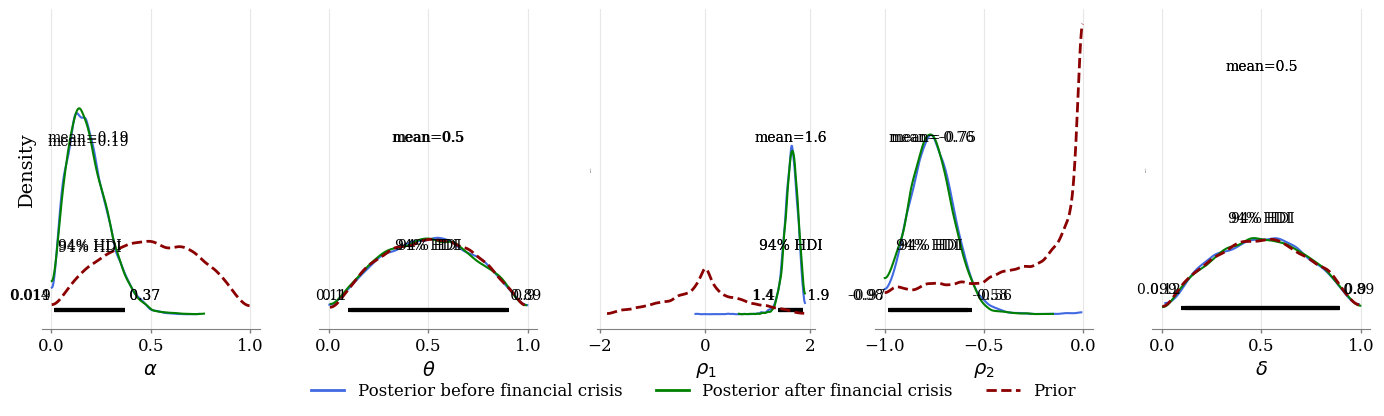

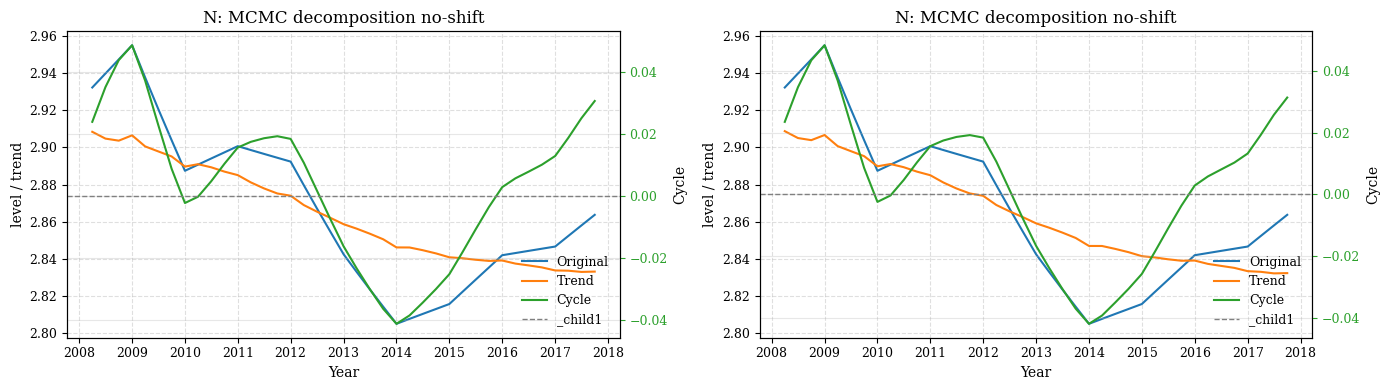

In [ ]:
prior_pred_case1 = Predictive(model_case1, num_samples=10000)
prior_draws_case1 = prior_pred_case1(rng, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1, N=N_1, l=len(pi_1))
params = ["alpha", "theta", "rho_1", "rho_2", "delta"]
labels = [r"$\alpha$", r"$\theta$", r"$\rho_{1}$", r"$\rho_{2}$", r"$\delta$"]

prior_dict_case1 = {k: prior_draws_case1[k] for k in params if k in prior_draws_case1}
idata_prior_case1 = az.from_dict(prior=prior_dict_case1)

fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)
axes_flat = axes.ravel()
for ax, param, label in zip(axes_flat, params, labels):
    az.plot_posterior(
        idata_case1_1,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_case2_1,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    if hasattr(idata_prior_case1, "prior") and (param in idata_prior_case1.prior.data_vars):
        az.plot_dist(
            idata_prior_case1.prior[param],
            ax=ax,
            color="darkred",
            fill_kwargs=None,
            plot_kwargs={"ls": "--", "lw": 2},
        )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

for i, ax in enumerate(axes_flat):
    ax.set_ylabel("Density", fontsize=14 if i % 5 == 0 else 0)
    if i % 2 == 1:
        ax.set_ylabel("")

for j in range(len(params), len(axes_flat)):
    axes_flat[j].axis("off")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred",  lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

scale = 2
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=False)
# First decomposition: no shift
plot_decomposition_ax(
    axes[0],
    data_1["DATE"], data_1["N"], N_bar_mean_case1_1, N_hat_mean_case1_1,
    "N: MCMC decomposition no-shift", loc="lower right"
)
plot_decomposition_ax(
    axes[1],
    data_1["DATE"], data_1["N"], N_bar_mean_case2_1, N_hat_mean_case2_1,
    "N: MCMC decomposition no-shift", loc="lower right"
)
plt.tight_layout()
plt.show()

# case 2

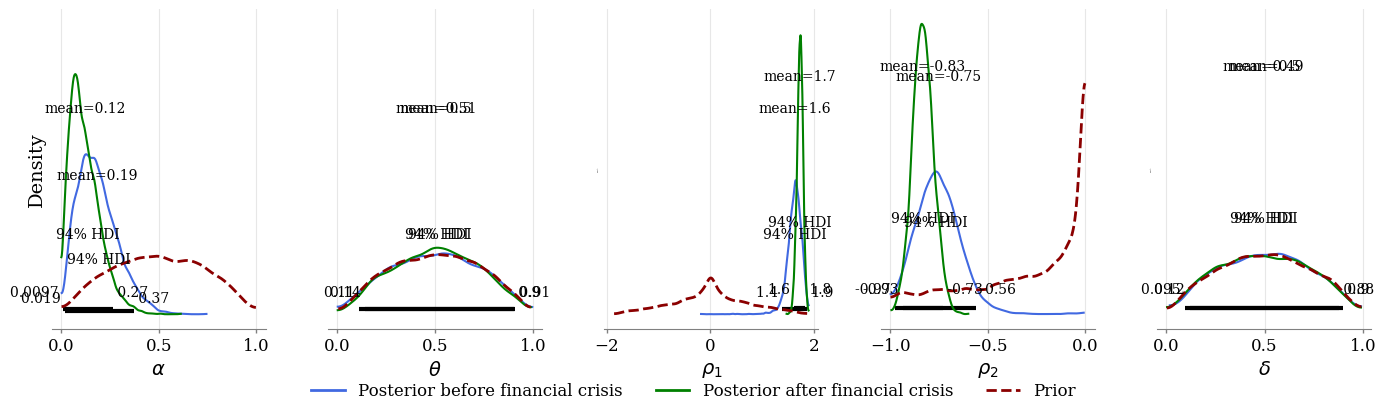

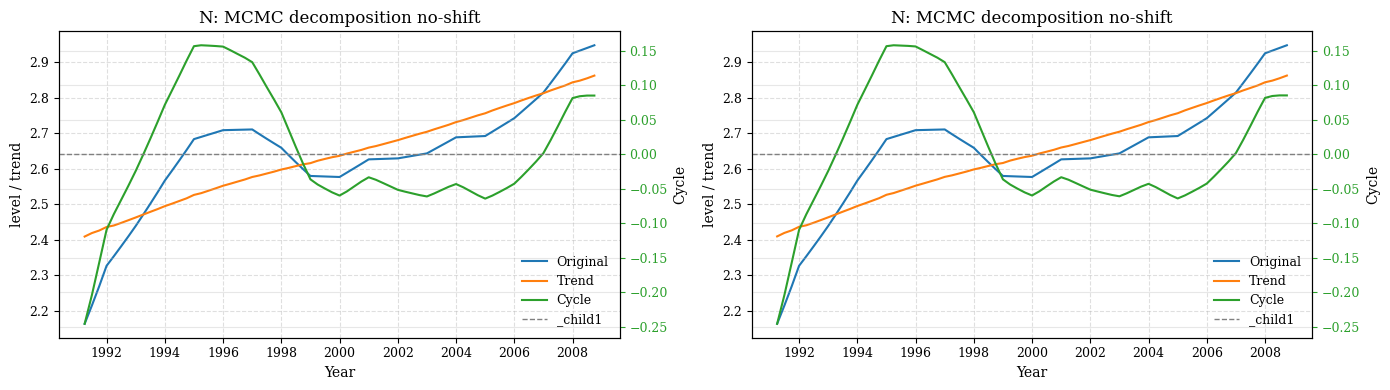

In [ ]:
prior_pred_case2 = Predictive(model_case1, num_samples=10000)
prior_draws_case2 = prior_pred_case2(rng, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_markup_2, N=N_2, l=len(pi_2))
params = ["alpha", "theta", "rho_1", "rho_2", "delta"]
labels = [r"$\alpha$", r"$\theta$", r"$\rho_{1}$", r"$\rho_{2}$", r"$\delta$"]

prior_dict_case2 = {k: prior_draws_case2[k] for k in params if k in prior_draws_case2}
idata_prior_case2 = az.from_dict(prior=prior_dict_case2)

fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)
axes_flat = axes.ravel()
for ax, param, label in zip(axes_flat, params, labels):
    az.plot_posterior(
        idata_case1_2,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_case2_2,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    if hasattr(idata_prior_case2, "prior") and (param in idata_prior_case2.prior.data_vars):
        az.plot_dist(
            idata_prior_case2.prior[param],
            ax=ax,
            color="darkred",
            fill_kwargs=None,
            plot_kwargs={"ls": "--", "lw": 2},
        )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

for i, ax in enumerate(axes_flat):
    ax.set_ylabel("Density", fontsize=14 if i % 5 == 0 else 0)
    if i % 2 == 1:
        ax.set_ylabel("")

for j in range(len(params), len(axes_flat)):
    axes_flat[j].axis("off")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred",  lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

scale = 2
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=False)
# First decomposition: no shift
plot_decomposition_ax(
    axes[0],
    data_2["DATE"], data_2["N"], N_bar_mean_case1_2, N_hat_mean_case1_2,
    "N: MCMC decomposition no-shift", loc="lower right"
)
plot_decomposition_ax(
    axes[1],
    data_2["DATE"], data_2["N"], N_bar_mean_case2_2, N_hat_mean_case2_2,
    "N: MCMC decomposition no-shift", loc="lower right"
)
plt.tight_layout()
plt.show()